# Chapter 4. CNN for images

This notebook illustrates the use of CNN models for the identification of images of filtered resonant arguments for the $s-s_6-g_5 + g_6$ node secular resonance.  To save disk space, we are providing a limited number of images, so the results are purely illustrative. Below there are the necessary commands to run the model.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from PIL import Image
from sys import getsizeof
import copy
import time
import datetime
import tracemalloc

2024-03-19 10:52:51.156832: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 10:52:51.181113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 10:52:51.181141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 10:52:51.182163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 10:52:51.188511: I tensorflow/core/platform/cpu_feature_guar

In [2]:
start_time = time.time()
# Starting monitoring the process
tracemalloc.start()

class_names = ['circulation state', 'switching orbits', 'libration state']

In [3]:
# read data
def read_data(filename, Images_loc, Labels, set_type):
    data_ast = pd.read_csv(filename,
                           skiprows=0,
                           header=None,
                           delim_whitespace=True,
                           index_col=None,
                           names = Labels,
                           low_memory=False,
                           dtype={'id': np.int64,
                                  'a': np.float64,
                                  'e': np.float64,
                                  'sin_i': np.float64,
                                  'Mag': np.float64,
                                  'freq': np.float64,
                                  'label': np.int64
                                  }
                           )
    n_lines =int(len(data_ast))
    data= data_ast.iloc[0:n_lines, :]
    data_id = list(data_ast.id)
    img = [Images_loc + str("{:07d}".format(ast_id)) + '.png' for ast_id in data_id]
    width, height = Image.open(img[0]).convert('1').size
    images = [np.array(Image.open(x).convert('1').getdata()).reshape(width, height) for x in img]
    im_labels = data_ast.label

    print(f'The size of the variable images is : {getsizeof(images)} bytes')
    print(f'We have {len(images)} images ({width} X {height} pixels) in the ', set_type, ' set, belonging to '
          f'{len(set(im_labels))} classes:')
    for i in range(len(set(im_labels))):
        print(f'   {len([x for x in im_labels if x == i])} asteroids in {class_names[i]} (label: {i})')
        print()
    return images, im_labels, data, data_id

In [4]:
filename_train = './TRAINING/res_status_all'
Images_loc_train = './TRAINING/res_'
names_train = ['id', 'a', 'e', 'sin_i', 'Mag', 'freq', 'label']
set_type = 'training'

train_images, train_labels, train_data, train_id = read_data(filename_train,Images_loc_train, names_train, set_type)

min_pixel = min(list(map(min, train_images[0])))
max_pixel = max(list(map(max, train_images[0])))
print(f'The pixel values of each image vary from {min_pixel} to {max_pixel}')


The size of the variable images is : 792 bytes
We have 78 images (100 X 100 pixels) in the  training  set, belonging to 3 classes:
   32 asteroids in circulation state (label: 0)

   14 asteroids in switching orbits (label: 1)

   32 asteroids in libration state (label: 2)

The pixel values of each image vary from 0 to 255


In [5]:
filename_test = './TEST/res_status_all'
Images_loc_test = './TEST/res_'
names_test = ['id', 'a', 'e', 'sin_i', 'Mag', 'freq', 'label']
set_type = 'testing'

test_images, test_labels, test_data, test_id = read_data(filename_test,Images_loc_test, names_test, set_type)


The size of the variable images is : 472 bytes
We have 50 images (100 X 100 pixels) in the  testing  set, belonging to 3 classes:
   24 asteroids in circulation state (label: 0)

   4 asteroids in switching orbits (label: 1)

   22 asteroids in libration state (label: 2)



In [6]:
filename_val = './VALIDATION/res_status_all'
Images_loc_val = './VALIDATION/res_'
names_val = ['id', 'a', 'e', 'sin_i', 'Mag', 'freq', 'label']
set_type = 'validation'
val_images, val_labels, val_data, val_id = read_data(filename_val, Images_loc_val, names_val, set_type)

# preprocessing the data: rescale the pixels value to range from 0 to 1
train_images = train_images / max_pixel
test_images = test_images / max_pixel
val_images = val_images / max_pixel

The size of the variable images is : 312 bytes
We have 29 images (100 X 100 pixels) in the  validation  set, belonging to 2 classes:
   14 asteroids in circulation state (label: 0)

   0 asteroids in switching orbits (label: 1)



In [7]:
# Define data augmentation
data_augmentation = keras.Sequential(
    [tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(100,100,1)),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
     ]
)

In [8]:
# Set up the model
def define_model_VGG():
    model = Sequential()
    model.add(data_augmentation)
    model.add(Conv2D(train_images.shape[1], (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100,1)))
    model.add(Conv2D(train_images.shape[1], (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    return model


In [9]:
# Set up the model
def define_model_Inception():
    model = Sequential()
    model.add(data_augmentation)
    model.add(Conv2D(64, (1, 1), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100,1)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100,1)))
    model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((3, 3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    return model

In [10]:
# Set up the model
def define_model_ResNet():
    model = Sequential()
    model.add(data_augmentation)
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100,1)))
    model.add(Conv2D(64, (3, 3), activation='linear', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100,1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    return model

In [12]:
checkpoint = ModelCheckpoint('./weights.hdf5',
                             save_weights_only=True,
                             monitor='accuracy',
                             mode='max',
                             verbose=1,
                             save_best_only=True,)

In [13]:
start_time = time.time()
# starting the monitoring
tracemalloc.start()


In [14]:
model=define_model_Inception()
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      128       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 33, 33, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 33, 33, 64)        0         
                                                      

In [15]:
x = model.fit(train_images, train_labels, epochs=12, callbacks=[checkpoint],
              verbose = 0, validation_data=(val_images, val_labels))
model.load_weights('./weights.hdf5')
end_time = time.time()
exec_time = datetime.timedelta(seconds=(end_time - start_time))
print(f'\n --- The execution time was: {exec_time} (h:m:s) ---')
# displaying the memory: The output is given in form of (current, peak), i.e, current memory is the memory the code is currently using, Peak memory is the maximum space the program used while executing.
print(tracemalloc.get_traced_memory())


Epoch 1: accuracy improved from -inf to 0.25641, saving model to ./weights.hdf5

Epoch 2: accuracy improved from 0.25641 to 0.37179, saving model to ./weights.hdf5

Epoch 3: accuracy improved from 0.37179 to 0.42308, saving model to ./weights.hdf5

Epoch 4: accuracy improved from 0.42308 to 0.47436, saving model to ./weights.hdf5

Epoch 5: accuracy did not improve from 0.47436

Epoch 6: accuracy did not improve from 0.47436

Epoch 7: accuracy did not improve from 0.47436

Epoch 8: accuracy improved from 0.47436 to 0.61538, saving model to ./weights.hdf5

Epoch 9: accuracy improved from 0.61538 to 0.66667, saving model to ./weights.hdf5

Epoch 10: accuracy did not improve from 0.66667

Epoch 11: accuracy did not improve from 0.66667

Epoch 12: accuracy improved from 0.66667 to 0.70513, saving model to ./weights.hdf5

 --- The execution time was: 0:00:23.423197 (h:m:s) ---
(19634630, 91573820)


In [17]:
def summarize_diagnostics(x):
    fig = plt.figure()
    figure = fig.add_subplot(211)
    figure.plot(x.epoch, x.history['loss'], color='blue', label='train')
    figure.plot(x.epoch, x.history['val_loss'],color='orange', label='val')
    #plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Cross Entropy Loss: VGG')
    figure = fig.add_subplot(212)
    figure.plot(x.epoch, x.history['accuracy'], color='blue', label='train')
    figure.plot(x.epoch, x.history['val_accuracy'],color='orange', label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Classification Accuracy: VGG')
    #plt.show()
    plt.tight_layout()
    fig.savefig('history_model_VGG.png', format='png', dpi=300)
    plt.show()
    plt.close(fig)


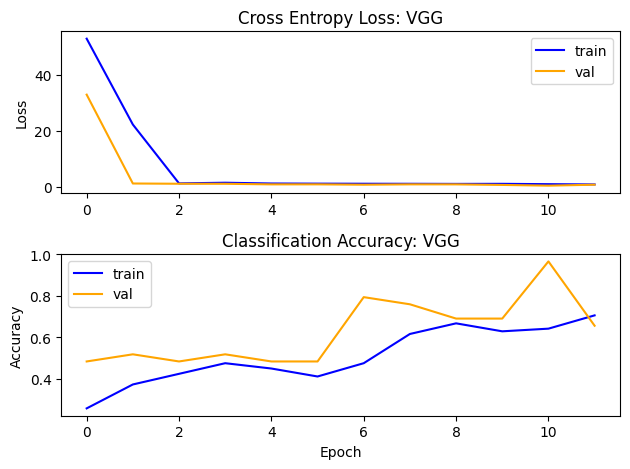

2/2 [==============================] - 0s 62ms/step



In [18]:
summarize_diagnostics(x)

predictions = model.predict(test_images)
predict_label = [int(np.argmax(x)) for x in predictions]
predict_acc = [100 * max(x) for x in predictions]

predicted_data = copy.deepcopy(test_data)
predicted_data['predicted_label'] = list(predict_label)
predicted_data.to_csv(r's_pred_data.csv', index=False, header=False, sep=' ', float_format='%.7f')
print()


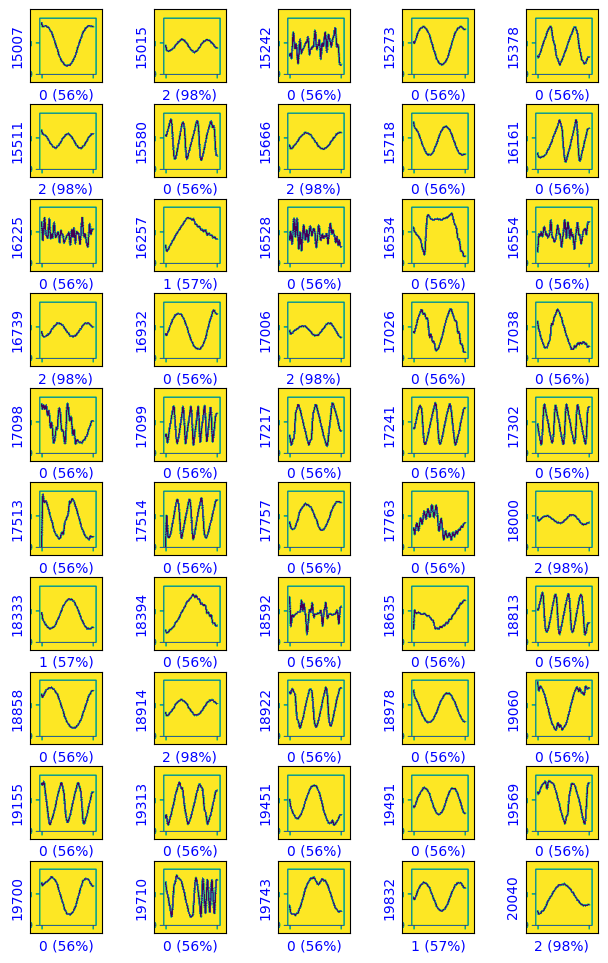

End


In [19]:
def show_images():
    fig = plt.figure(figsize=(8, 12))
    for i in range(50):
        plt.subplot(10, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[i])
        color = 'blue'
        plt.xlabel("{} ({:2.0f}%)".format(predict_label[i], predict_acc[predict_label[i]]),color=color, fontsize=10)
        plt.ylabel("{}".format(test_id[i]), color=color, fontsize=10)
    plt.subplots_adjust(hspace=0.3, wspace=0)
    # plt.show()
    fig.savefig('predicted_data.png', format='png', dpi=300)
    plt.show()
    plt.close(fig)

show_images()


print("End")